<a href="https://colab.research.google.com/github/Jorbnc/MAIA-RL/blob/master/RL_proyecto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importaciones

In [49]:
# Para anotar los tipos de argumentos del tablero
from typing import Tuple, List

# Para toma de decisiones
import random
import numpy as np

# Tiempo de Aprendizaje
import time

# Para visualización
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.animation as animation

from matplotlib.textpath import TextPath
from matplotlib.markers  import MarkerStyle
from matplotlib.path     import Path
from matplotlib.transforms import Affine2D
from matplotlib.patches  import PathPatch, FancyArrowPatch

np.random.seed(13)

# Tablero

In [17]:
#Validar que el número de celda esté dentro de los límites del tablero
def limites_validos(celda, celda_max) -> bool:
    return 1 <= celda <= celda_max

# Definición del ambiente
class Tablero:
    def __init__(
        self,
        nro_filas: int,
        nro_columnas: int,
        celda_victoria: int,
        celdas_perdida: List[int],
        celdas_escalera: List[Tuple[int]],
        celdas_rodadero: List[Tuple[int]],
    ):
        # ----------------------------------------------------------------------
        # Validación de condiciones mínimas para el tablero
        if nro_filas < 2 or nro_columnas < 2:
            raise ValueError("Debe haber al menos 2 filas y 2 columnas")
        # $N= Filas x Columnas representa el número total de casillas del tablero
        self.celda_max = nro_filas * nro_columnas
        celdas_a_validar = ([celda_victoria] + celdas_perdida
                            + [celda for par in celdas_escalera for celda in par]
                            + [celda for par in celdas_rodadero for celda in par]
                            )
        # Validamos las ubicaciones o estados dados por parámetros sean válidos
        for celda in celdas_a_validar:
            if not limites_validos(celda, self.celda_max):
                raise ValueError(f"{celda} fuera de los limites: {1} a {self.celda_max}")

        # Una celda de pérdida no puede ser una celda de victoria
        for c in celdas_perdida:
            if c == celda_victoria:
                raise ValueError(f"Estado de pérdida {c} debe ser diferente a estado de victoria {celda_victoria}")

        # ----------------------------------------------------------------------
        # Definición de Atributos
        self.nro_filas = nro_filas
        self.nro_columnas = nro_columnas
        self.celda_victoria = celda_victoria
        self.celdas_perdida = celdas_perdida
        self.celdas_escalera = celdas_escalera
        self.celdas_rodadero = celdas_rodadero

        # Mismo diccionario para las transiciones de las escaleras y de los rodaderos
        self.escaleras_y_rodaderos = {**dict(celdas_escalera), **dict(celdas_rodadero)}

        # Definición de la recompensa para: ganar o perder el juego
        self.reward_map = {
            self.celda_victoria: 1.0,
            **{cell: -1.0 for cell in self.celdas_perdida}
        }

    #Representación impresa del Tablero
    def __repr__(self) -> str:

        atributos = [
            ("Número de filas", self.nro_filas),
            ("Número de columnas", self.nro_columnas),
            ("Celda máxima", self.celda_max),
            ("Celda victoria", self.celda_victoria),
            ("Celdas perdida", self.celdas_perdida),
            ("Celdas escalera", self.celdas_escalera),
            ("Celdas rodadero", self.celdas_rodadero),
        ]
        atributos_str = "\n".join(f" {nombre}: {valor}" for nombre, valor in atributos)
        return f"Tablero:\n{atributos_str}\n"

    # Obtener coordenada (columna, fila) a partir del número de celda y el número de columnas
    def celda_a_coord(self, nro_celda) -> tuple[int, int]:

        # -1 para manejar los multiplos de 'nro_columnas'
        fila = ((nro_celda - 1) // self.nro_columnas) + 1
        offset = (nro_celda - 1) % self.nro_columnas

        # Fila impar
        if fila % 2 == 1:
            # Izquierda a derecha
            columna = offset + 1
        else:
            # Derecha a izquierda
            columna = self.nro_columnas - offset
        # Centrar
        return (columna - 0.5, fila - 0.5)

    #Obtener el número de celda a partir del par: (columna, fila)
    def coord_a_celda(self, col, fila) -> int:

        valor_inicial = (fila - (fila % 2)) * self.nro_columnas
        offset = (-1) ** (fila - 1) * (col - ((fila - 1) % 2))
        return valor_inicial + offset

    # Saber si el estado es terminal
    def is_terminal(self, estado) -> bool:
        return estado == self.celda_victoria or estado in self.celdas_perdida

# Para exportar/importar con `from Tablero import`
__all__ = ["limites_validos", "Tablero"]

# Agente

In [18]:
class AgenteQLearning: # Sugiero cambiar nombre para la primera entrega
    def __init__(self, tablero: Tablero, alpha: float = 0.1, gamma: float = 0.9, epsilon: float = 0.1):

        # Ambiente
        self.tablero = tablero

        # Parámetros del agente (algunos parámetros podrían ajustarse en la entrega final, por ahora se usan parámetros escogidos al azar)
        # Tasa de aprendizaje
        self.alpha = alpha
        # Factor de descuento
        self.gamma = gamma
        # Ratio de exploración
        self.epsilon = epsilon
        # Posición inicial siempre en 1
        self.pos = 1
        # Izquierda/Derecha o Avanzar/ Retroceder
        self.acciones = [-1, 1]

        # Q-table (o Q-dict en nuestro caso)
        self.Q = {}  # No va entrega parcial

    #Escoge una acción
    def escoger_accion(self, estado) -> int:

        # De de acá....
        # Exploración
        if random.random() < self.epsilon:
            return random.choice(self.acciones)

        # Explotación
        else:
            # Obtener los mejores valores Q (0 en caso aún no exista)
            Q_vals = [self.Q.get((estado, a), 0.0) for a in self.acciones]
            Q_max = max(Q_vals)

            # En caso de empate, escoger aleatoriamente una acción
            mejores_acciones = [a for a, Q in zip(self.acciones, Q_vals) if Q == Q_max]
            return random.choice(mejores_acciones)
          # Hasta acá no iría en la entrega parcial

        # Iría en la entrega parcial:
        # if self.tablero.is_terminal(estado):
        #   return None
        # else:
        #   return random.choice(self.acciones)


    # De de acá....
    def actualizar_Q(self, estado, accion, reward, estado_siguiente) -> None:
        """
        Actualización Q-learning con base en(Sₜ,Aₜ,Rₜ,Sₜ₊₁):
            Q(Sₜ,Aₜ) = Q(Sₜ,Aₜ) + α[Rₜ₊₁ + γ*maxₐ Q(Sₜ₊₁,a) - Q(Sₜ,Aₜ)]    (Sutton & Barto, p. 131)
        """
        Q_actual = self.Q.get((estado, accion), 0.0)

        # Estimar mejor Q en el siguiente estado
        Q_vals_siguiente_max = max([self.Q.get((estado_siguiente, a), 0.0) for a in self.acciones])

        # Actualización
        # TODO: Probar si hay cambios importantes al variar gamma
        self.Q[(estado, accion)] = Q_actual + self.alpha * (reward + self.gamma * Q_vals_siguiente_max - Q_actual)
    # Hasta acá no iría en la entrega parcial

    #Definición de función de transición
    def transicion(self, estado, accion):
        if accion != None:
          estado_siguiente = estado + accion

          estado_siguiente = self.tablero.escaleras_y_rodaderos.get(
              # Si el estado_siguiente es el inicio de una escalera/rodadero, entonces retorna el final
              estado_siguiente,
              # En caso contrario, solo valida el estado_siguiente
              max(1, min(estado_siguiente, self.tablero.celda_max))
          )
          # Aclaración: No se evalua condición de terminación. Esto será manejado la fase de simulación
          return estado_siguiente
        else:
          return estado

    #Función de recompensa basado en un mapeo (diccionario): Sₜ₊₁ -> reward
    def reward(self, estado_siguiente):
        return self.tablero.reward_map.get(estado_siguiente, 0)


    #Representa un paso en la simulación con base en las condiciones actuales.
    #Actualiza la Q-table con base en (Sₜ,Aₜ,Rₜ,Sₜ₊₁) y retorna la tupla. # No va entrega parcial

    def step(self) -> Tuple[int, int, float, int]:
        estado = self.pos
        accion = self.escoger_accion(estado)

        # Transición y Reward del paso actual
        estado_siguiente = self.transicion(estado, accion)
        reward = self.reward(estado_siguiente)

        # Actualizar Q y estado (pos) # No va entrega parcial
        self.actualizar_Q(estado, accion, reward, estado_siguiente) # No va entrega parcial
        self.pos = estado_siguiente

        return estado, accion, reward, estado_siguiente

# Visualización

In [64]:
# Vectores unitarios espaciados entre u→v
def _vector(u, v, n):

    pts = np.linspace(u, v, n)
    return np.diff(pts, axis=0)

# Path (cubic Bézier) con curvatura aleatoria entre puntos u y v
def _rand_curve(u, v, amp=2.85, n_sub=120):
    # puntos de control (como antes, pero separamos ruido en X y Y)
    dx, dy = v[0]-u[0], v[1]-u[1]
    perp   = np.array([-dy, dx])              # vector ortogonal
    perp   = perp / np.linalg.norm(perp)

    ctrl1 = np.array(u) + 0.3*np.array([dx, dy]) + perp*amp*np.random.uniform(-1,1)
    ctrl2 = np.array(u) + 0.7*np.array([dx, dy]) - perp*amp*np.random.uniform(-1,1)

    # Path Bézier
    bez = Path([u, ctrl1, ctrl2, v],
               [Path.MOVETO, Path.CURVE4, Path.CURVE4, Path.CURVE4])

    t  = np.linspace(0, 1, n_sub)
    # función de Bézier cúbica
    B  = lambda p0,p1,p2,p3,t: (1-t)**3 * p0 + 3*(1-t)**2*t * p1 + 3*(1-t)*t**2 * p2 + t**3 * p3
    Px = B(bez.vertices[0,0], bez.vertices[1,0], bez.vertices[2,0], bez.vertices[3,0], t)
    Py = B(bez.vertices[0,1], bez.vertices[1,1], bez.vertices[2,1], bez.vertices[3,1], t)
    verts = np.column_stack([Px, Py])
    codes = [Path.MOVETO] + [Path.LINETO]*(len(verts)-1)
    return Path(verts, codes)

# Línea principal + barrotes intermedios
def dibujar_escalera(
        ax,
        u, v,                    # coordenadas inicio → fin (x,y)
        color='#2ecc71',         # verde pastel
        rungs=6,                 # número de “barrotes”
        width=6,                 # grosor de líneas
        rung_ratio=0.20,         # longitud relativa de cada barrote
        shadow_offset=(0.03, -0.03)  # desplazamiento sombra
    ):
    """
    Dibuja una escalera con:
        • barandas redondeadas
        • barrotes perpendiculares
        • ligero ‘drop-shadow’ para efecto cartoon
    """
    # ── Sombra (PathPatch desplazado) ──────────────────────────
    main_path = Path([u, v], [Path.MOVETO, Path.LINETO])
    shadow = PathPatch(
        main_path,
        lw=width,
        capstyle='round', joinstyle='round',
        edgecolor='k', alpha=.08,          # sombra gris suave
        zorder=1,
        transform=Affine2D().translate(*shadow_offset) + ax.transData
    )
    ax.add_patch(shadow)

    # ── Baranda principal ──────────────────────────────────────
    ax.plot(
        [u[0], v[0]], [u[1], v[1]],
        lw=width, color=color,
        solid_capstyle='round', zorder=2
    )

    # ── Calcular barrotes (perpendiculares) ────────────────────
    u_vec = np.array(u); v_vec = np.array(v)
    # (1) vectores entre puntos consecutivos
    steps = np.linspace(u_vec, v_vec, rungs+2)[1:-1]   # evita extremos
    # (2) vector ortogonal unitario
    side = v_vec - u_vec
    ortho = np.array([-side[1], side[0]])
    ortho /= np.linalg.norm(ortho)
    ortho *= rung_ratio * np.linalg.norm(side) / rungs

    # ── Dibujar cada barrote y su sombra ───────────────────────
    for p in steps:
        p1, p2 = p - ortho, p + ortho

        # sombra del barrote
        ax.plot(
            [p1[0]+shadow_offset[0], p2[0]+shadow_offset[0]],
            [p1[1]+shadow_offset[1], p2[1]+shadow_offset[1]],
            lw=width, color='k', alpha=.08, zorder=1,
            solid_capstyle='round'
        )
        # barrote principal
        ax.plot(
            [p1[0], p2[0]], [p1[1], p2[1]],
            lw=width, color=color, zorder=2,
            solid_capstyle='round'
        )


# Curva con relleno suave
def dibujar_rodadero(ax, u, v, color='#e74c3c'):
    path = _rand_curve(u, v, amp=.5, n_sub=120)

    # Sombra
    ax.add_patch(PathPatch(
        path, lw=6, edgecolor='k', alpha=.08, zorder=1,
        transform=Affine2D().translate(0.03, -0.03) + ax.transData))

    # Línea principal
    ax.add_patch(PathPatch(
        path, lw=6, edgecolor=color, facecolor='none',
        capstyle='round', joinstyle='round', zorder=2))

    # Flecha de salida
    ax.add_patch(FancyArrowPatch(
        path.vertices[-2], path.vertices[-1],
        arrowstyle='simple', mutation_scale=16,
        color=color, lw=0, zorder=3))

# Plotear el tablero, se mostrará una animación con el recorrido del agente.
def plot_tablero(tablero, trayectoria=None) -> None:

    nro_filas, nro_columnas = tablero.nro_filas, tablero.nro_columnas

    fig, ax = plt.subplots(figsize=(nro_columnas, nro_filas), dpi=75)
    ax.set_xlim(0, nro_columnas)
    ax.set_ylim(0, nro_filas)
    ax.set_xticks(range(1, nro_columnas + 1))
    ax.set_yticks(range(1, nro_filas + 1))
    ax.grid(color="black", linewidth=1)
    ax.tick_params(
        axis="both", which="both",
        bottom=False, top=False, left=False, right=False,
        labelbottom=False, labelleft=False,
    )

    # Anotar el número de celda
    for fila in range(1, nro_filas + 1):
        for col in range(1, nro_columnas + 1):
            nro_celda = tablero.coord_a_celda(col, fila)
            ax.text(col - 0.5, fila - 0.35, str(nro_celda), ha="center", va="bottom", alpha=0.5)

    # Posición de victoria
    vic_coord = tablero.celda_a_coord(tablero.celda_victoria)
    ax.text(*vic_coord, "FIN", ha="center", va="top", color="green", size=15)

    # Posiciones de pérdida
    tp = TextPath((0, 0), '\N{SKULL AND CROSSBONES}', size=1)
    bbox = tp.get_extents()
    dx = - (bbox.x0 + bbox.width  / 2)
    dy = - (bbox.y0 + bbox.height / 2)
    tp_centered = tp.transformed(Affine2D().translate(dx, dy))
    skull_marker = MarkerStyle(tp_centered)

    for celda in tablero.celdas_perdida:
        ax.scatter(*tablero.celda_a_coord(celda),
                  marker=skull_marker, s=3500, color='red', zorder=5)

    # Escaleras
    for a, b in tablero.celdas_escalera:
        u = tablero.celda_a_coord(a)
        v = tablero.celda_a_coord(b)
        dibujar_escalera(ax, u, v)
    # Rodaderos
    for a, b in tablero.celdas_rodadero:
        u = tablero.celda_a_coord(a)
        v = tablero.celda_a_coord(b)
        dibujar_rodadero(ax, u, v)

    # Animar trayectoria
    if trayectoria:
        # Figura del agente. Se actualiza iterativamente
        dot, = ax.plot([], [], 'bo', markersize=12)

        def actualizar_frame(frame):
            coord = tablero.celda_a_coord(trayectoria[frame])
            dot.set_data([coord[0]], [coord[1]])
            # tuple (con 1 solo elemento) para que FuncAnimation pueda 'iterar' y re-dibujar el dot
            return dot,

        anim = animation.FuncAnimation(
            fig,
            # Función para llamar por cada frame
            actualizar_frame,
            # Total de frames
            frames=len(trayectoria),
            interval=200,
            # loopear la animación
            repeat=True,
            # re-dibujar solo figuras que han cambiado
            blit=True,
        )

    plt.show()

# Simulación

In [33]:
#Correr simulación y plotear la última trayectoria
def run(tablero, agente, episodios=1000) -> None:

    reward_acumulado = []

    for episodio in range(episodios):
        # Reiniciar condiciones al inicio de cada episodio
        agente.pos = 1
        trayectoria = [agente.pos]
        pasos = 0

        # Recorrer tablero
        while True:
            estado, accion, reward, estado_siguiente = agente.step()
            pasos += 1
            trayectoria.append(estado_siguiente)
            reward_acumulado.append(reward)

            # Evaluar si hay condición de finalización
            if estado_siguiente == agente.tablero.celda_victoria or estado_siguiente in agente.tablero.celdas_perdida:
                print(f"Episodio {episodio + 1} terminó en {pasos} pasos, con reward {reward}.")
                break

    plot_tablero(tablero, trayectoria)

# Main

Episodio 1 terminó en 211 pasos, con reward -1.0.
Episodio 2 terminó en 83 pasos, con reward -1.0.
Episodio 3 terminó en 116 pasos, con reward -1.0.
Episodio 4 terminó en 574 pasos, con reward 1.0.
Episodio 5 terminó en 141 pasos, con reward -1.0.
Episodio 6 terminó en 236 pasos, con reward -1.0.
Episodio 7 terminó en 276 pasos, con reward -1.0.
Episodio 8 terminó en 393 pasos, con reward 1.0.
Episodio 9 terminó en 513 pasos, con reward 1.0.
Episodio 10 terminó en 152 pasos, con reward 1.0.
Episodio 11 terminó en 387 pasos, con reward 1.0.
Episodio 12 terminó en 333 pasos, con reward -1.0.
Episodio 13 terminó en 467 pasos, con reward 1.0.
Episodio 14 terminó en 305 pasos, con reward 1.0.
Episodio 15 terminó en 295 pasos, con reward 1.0.
Episodio 16 terminó en 368 pasos, con reward 1.0.
Episodio 17 terminó en 358 pasos, con reward 1.0.
Episodio 18 terminó en 195 pasos, con reward -1.0.
Episodio 19 terminó en 884 pasos, con reward 1.0.
Episodio 20 terminó en 437 pasos, con reward 1.0.
Ep

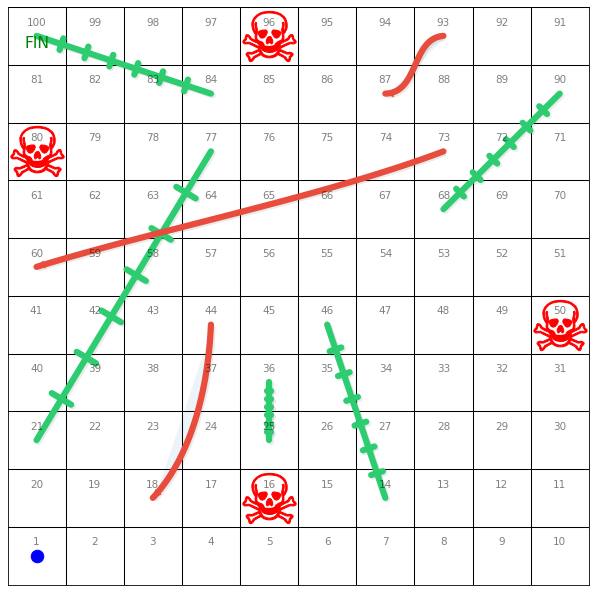

In [65]:
# Definición de un tablero adecuado para el problema
tab = Tablero(
    nro_filas=10,
    nro_columnas=10,
    celda_victoria=100,
    celdas_perdida=[16, 50, 80, 96],
    celdas_escalera=[(14, 46), (21, 77), (25, 36), (68, 90), (84, 100)],
    celdas_rodadero=[(44, 18), (73, 60), (93, 87)],
)
agente = AgenteQLearning(tab, epsilon=0.1, gamma=0.5)
run(tab, agente, episodios=100)